In [1]:
!cd ..
!pwd

/content


In [2]:
%%capture
!rm -r GETAM
!git clone https://github.com/Hammad-Mir/GETAM

In [3]:
%%capture
! pip install timm

In [4]:
%%capture
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

In [5]:
! pwd

/content


In [6]:
import os
import cv2
import tarfile
import numpy as np
import pandas as pd
from math import ceil
from time import time
from tqdm.auto import tqdm
import multiprocessing as mp
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import timm
import torch
import torchvision
import torchsummary
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
#from torch.utils.tensorboard import SummaryWriter

%matplotlib inline

In [7]:
os.chdir(f'./GETAM')

In [8]:
import myTool as mytool
#from DenseEnergyLoss import DenseEnergyLoss
from DPT.DPT import DPT, DPTSegmentationModel
from tool import pyutils, imutils, torchutils
from myTool import compute_joint_loss, compute_seg_label_3, validation

In [9]:
np.random.seed(42)
torch.manual_seed(42)

# Setting up GPU

In [10]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

# Extracting images to local storage

In [13]:
!rm -r /content/Dataset
!rm -r /content/data_border_constant
!rm -r /content/data_border_reflect

In [14]:
my_tar = tarfile.open('/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Dataset/Dataset.tar.xz')
my_tar.extractall('/content')
my_tar.close()

In [15]:
my_tar = tarfile.open('/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Dataset/data_bordered.tar.xz')
my_tar.extractall('/content')
my_tar.close()

# Image path list

In [16]:
original_image_path = '/content/Dataset/1.training/1.training'
cutmix_image_path = '/content/Dataset/cutmix_augmentation'
constant_image_path = '/content/data_border_constant'
reflect_image_path = '/content/data_border_reflect'

In [17]:
image_path_list = []

In [18]:
def img_list(data_path):
  # getting list of all the images
  images = os.listdir(data_path)
  #exc_list = ['[1, 1, 0]', '[1, 0, 1]', '[0, 1, 1]', '[1, 1, 1]']
  # setting the flag based on the image path
  '''
  if path == orig_image_path:
    flag = 0
  else:
    flag = 1
  '''
  # don't need the flag, just resize all the images while loading to (224, 224)

  # adding to the image_path_list
  for i in images:
    # adding the image path, flag and the label
    #image_path_list[0].append([path + '/' + str(i), flag, list(map(int, i[-13:-4].strip('][').split(', ')))])
    #print(list(map(int, i[-13:-4].strip('][').split(', '))))
    if 'DS_S' in str(i):
      continue
    image_path_list.append([data_path + '/' + str(i), list(map(int, i[-13:-4].strip('][').split(', ')))])

In [19]:
# loading image paths
img_list(original_image_path)
img_list(cutmix_image_path)
img_list(constant_image_path)
img_list(reflect_image_path)

In [20]:
np.random.shuffle(image_path_list)

In [21]:
# sorting the image path list from the original list to match the number of tumor-stroma pair to the rest of the dataset and the cut-mix aug data
tumor = [x for x in image_path_list if '[1, 0, 0]' in x[0]]
stroma = [x for x in image_path_list if '[0, 1, 0]' in x[0]]
normal = [x for x in image_path_list if '[0, 0, 1]' in x[0]]
tum_str = [x for x in image_path_list if '[1, 1, 0]' in x[0]][:4000]
str_nor = [x for x in image_path_list if '[0, 1, 1]' in x[0]]
tum_nor = [x for x in image_path_list if '[1, 0, 1]' in x[0]]
all_tis = [x for x in image_path_list if '[1, 1, 1]' in x[0]]

In [22]:
np.random.shuffle(tumor)
np.random.shuffle(stroma)
np.random.shuffle(normal)
np.random.shuffle(tum_str)
np.random.shuffle(str_nor)
np.random.shuffle(tum_nor)
np.random.shuffle(all_tis)

In [23]:
test_list =[]
train_list = []

In [24]:
# train test splits
tumor, test = train_test_split(tumor, test_size = 0.2, train_size = 0.8, random_state = 42)
test_list.extend(test)

stroma, test = train_test_split(stroma, test_size = 0.2, train_size = 0.8, random_state = 42)
test_list.extend(test)

normal, test = train_test_split(normal, test_size = 0.2, train_size = 0.8, random_state = 42)
test_list.extend(test)

tum_str, test = train_test_split(tum_str, test_size = 0.2, train_size = 0.8, random_state = 42)
test_list.extend(test)

str_nor, test = train_test_split(str_nor, test_size = 0.2, train_size = 0.8, random_state = 42)
test_list.extend(test)

tum_nor, test = train_test_split(tum_nor, test_size = 0.2, train_size = 0.8, random_state = 42)
test_list.extend(test)

all_tis, test = train_test_split(all_tis, test_size = 0.2, train_size = 0.8, random_state = 42)
test_list.extend(test)

In [25]:
train_list.extend(tumor)
train_list.extend(stroma)
train_list.extend(normal)
train_list.extend(tum_str[:2000])
train_list.extend(str_nor)
train_list.extend(tum_nor)
train_list.extend(all_tis)

In [26]:
np.random.shuffle(train_list)

In [27]:
len(train_list)

18073

In [28]:
len(test_list)

4821

## Creating the dataset class

In [29]:
# Creating the dataset class for the data

class LUAD(Dataset):
  """Lung Adenocarcinoma Histopathological images."""
  
  def __init__(self, image_list, transform = None):
    
    """
      Args:
        image_list: csv/list/numpy array containing image paths, flag and labels.
        transform (callable, optional): Optional transform to be applied on a sample.
        """
    #Loading the csv file containing the image paths and one-hot encoded labels
    #self.image_paths_labels = pd.read_csv(csv_file)
    self.image_list = image_list
    self.transform = transform

  def __len__(self):
    return len(self.image_list)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    # code when input is a csv file
    '''
    image = cv2.imread(image_paths_labels.iloc[idx, 0])
    image = transforms.ToTensor()(image)                # converts cv2 image (H, W, C) to pytorch tensor (C, H, W) do this in transforms
    labels = self.image_paths_labels.iloc[idx, 1]
    labels = np.array([labels])
    labels = labels.astype('int').reshape(-1, 3)        # check what exactly to do with this
    sample = {'image': image, 'labels': labels}
    '''
    #print(idx) keeps printing 
    # code when the input is a list of image paths and labels
    image = cv2.imread(self.image_list[idx][0])
    #image = transforms.ToTensor()(image)                # converts cv2 image (H, W, C) to pytorch tensor (C, H, W)
    labels = self.image_list[idx][1]
    labels = np.array([labels])
    #labels = labels.astype('int').reshape(-1, 3) #.argmax(axis=1)        # reshapes the labels array into (n, 3) array
    labels = labels.astype('float32').reshape(-1)
    #sample = {'image': image, 'labels': labels}
    
    if self.transform:
      #sample = self.transform(sample)
      image = self.transform(image)
    
    return image, labels

18073
0 (224, 224, 3) (3,)
1 (229, 162, 3) (3,)
2 (214, 195, 3) (3,)
3 (224, 224, 3) (3,)


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


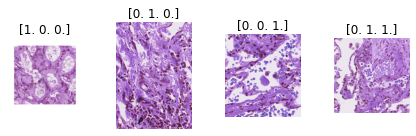

In [30]:
# check if the dataloader works
check_loader = LUAD(image_list=train_list)

print(len(check_loader))
fig = plt.figure()

for i in range(len(check_loader)):
    #sample = check_loader[i]
    image, labels = check_loader[i]

    print(i, image.shape, labels.shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    #ax.set_title(sample['labels'])
    ax.set_title(labels)
    ax.axis('off')
    #plt.imshow(sample['image'])
    plt.imshow(image)

    if i == 3:
        plt.show()
        break

In [31]:
random_augs = [#transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
               #transforms.RandomGrayscale(p=0.1),            #Grayscale(num_output_channels=3),
               #transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
               transforms.RandomHorizontalFlip(p=0.5),
               transforms.RandomVerticalFlip(p=0.5),
               transforms.RandomRotation(30),
               #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
               #transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
               #transforms.RandomAdjustSharpness(sharpness_factor=2),
               ]

# creatin the train dataset
train_dataset = LUAD(train_list,
                     transform = transforms.Compose([transforms.ToTensor(),
                                                     transforms.Resize((224, 224)),
                                                     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
                                                     transforms.RandomApply(random_augs, p=0.6),
                                                     ]))

# creating the test dataset
test_dataset = LUAD(test_list,
                    transform = transforms.Compose([transforms.ToTensor(),
                                                    transforms.Resize((224, 224)),
                                                    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),]
                                                    ))

In [32]:
batch_size = 64

In [33]:
# train dataloader
train_dataloader = DataLoader(train_dataset,
                              batch_size = batch_size,
                              shuffle = True,
                              num_workers = 1,
                              )

# test dataloader
test_dataloader = DataLoader(test_dataset,
                             batch_size = batch_size,
                             shuffle = True,
                             num_workers = 1,
                             )

In [34]:
len(train_dataloader)

283

# Creating the Model

In [35]:
GETAM_model = DPTSegmentationModel(num_classes=3, backbone_name='vitb16_224').to(device)

cur_backbone: vitb16_224


In [36]:
torchsummary.summary(GETAM_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
           Dropout-2             [-1, 197, 768]               0
         LayerNorm-3             [-1, 197, 768]           1,536
            Linear-4            [-1, 197, 2304]       1,771,776
           Dropout-5         [-1, 12, 197, 197]               0
            Linear-6             [-1, 197, 768]         590,592
           Dropout-7             [-1, 197, 768]               0
         Attention-8             [-1, 197, 768]               0
          Identity-9             [-1, 197, 768]               0
        LayerNorm-10             [-1, 197, 768]           1,536
           Linear-11            [-1, 197, 3072]       2,362,368
             GELU-12            [-1, 197, 3072]               0
          Dropout-13            [-1, 197, 3072]               0
           Linear-14             [-1, 1

# Checking model properties

In [ ]:
next(GETAM_model.parameters()).is_cuda

In [ ]:
out = GETAM_model.forward_cls(torch.randn(10, 3, 224, 224).to(device))
out

In [ ]:
GETAM_model(torch.randn(1, 3, 224, 224).to(device))[1].shape

In [ ]:
y_p = nn.functional.sigmoid(out)
y_p

In [ ]:
#y_p = y_p.round().detach().cpu().numpy()
y_p = y_p.round()
#y_p = nn.Threshold(0.25, 1.0)(y_p)
y_p

In [ ]:
y_p.shape

In [ ]:
'''
l = np.array([[0, 0, 1],
              [1, 0, 0],
              [0, 0, 1],
              [0, 0, 1],
              [0, 0, 1],
              [0, 0, 1],
              [0, 1, 0],
              [1, 0, 0],
              [0, 0, 1],
              [0, 0, 1],]).astype('float32')
'''

l = np.array([[1., 1., 0.],
              [1., 0., 1.],
              [1., 1., 0.],
              [1., 1., 1.],
              [1., 1., 0.],
              [1., 1., 0.],
              [1., 1., 1.],
              [0., 1., 1.],
              [1., 1., 1.],
              [0., 1., 1.]]).astype('float32')

In [ ]:
l = torch.tensor(l).to(device)

In [ ]:
accuracy_score(l.cpu().detach().numpy(),
               y_p.cpu().detach().numpy())

In [ ]:
loss = nn.CrossEntropyLoss()

In [ ]:
loss(out, l)

# Training and validation

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               opt: torch.optim.Optimizer,
               eval_fn = accuracy_score,
               device: torch.device = device
               ):
  
  train_loss, train_acc = 0, 0
  model.train()
  for batch, (x, y) in enumerate(data_loader):
    
    if (batch % 20 == 0) or (batch == len(data_loader)-1): print(f'batch: {batch}')
    #print(f'batch: {batch}')
    #x = data['image']
    #y = data['labels']
    # send data to GPU
    x, y = x.to(device), y.to(device)
    
    #clear gradients
    opt.zero_grad()

    # forward pass
    model_out = model.forward_cls(x)
    y_pred = torch.sigmoid(model_out).round()
    
    # calculate loss
    loss = loss_fn(model_out, y)
    #print(loss) Printed the loss per batch per epoch
    #print(y.shape)
    #print(y_pred.shape)
    #print(type(y))
    #print(type(y_pred))
    train_loss += loss
    train_acc += eval_fn(y.cpu().detach().numpy().astype('float32'),
                         y_pred.cpu().detach().numpy().astype('float32'))

    # back-prop
    loss.backward()

    # optimize
    opt.step()

  # Calculate loss and accuracy per epoch and print out what's happening
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.5f}")

In [ ]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              eval_fn = accuracy_score,
              device: torch.device = device
              ):
  test_loss, test_acc = 0, 0
  model.eval() # put model in eval mode
  
  # Turn on inference context manager
  with torch.inference_mode(): 
    for (X, y) in data_loader:

      #x = data['image']
      #y = data['labels']
      
      # Send data to GPU
      X, y = X.to(device), y.to(device)
      
      # 1. Forward pass
      model_out = model.forward_cls(X)
      test_pred = torch.sigmoid(model_out).round()
      
      # 2. Calculate loss and accuracy
      test_loss += loss_fn(model_out, y)
      test_acc += eval_fn(y.cpu().detach().numpy().astype('float32'),
                          test_pred.cpu().detach().numpy().astype('float32'))
      
    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.5f}\n")
    return test_loss, test_acc

In [37]:
def epoch_step(model: torch.nn.Module,
               train_data_loader: torch.utils.data.DataLoader,
               test_data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               opt: torch.optim.Optimizer,
               eval_fn = accuracy_score,
               device: torch.device = device
               ):

#######################################################################################################################
#                                                                                                                     #
#                                                    Training                                                         #
#                                                                                                                     #
#######################################################################################################################
  
  train_loss, train_acc = 0, 0
  # put model in training mode
  model.train()
  loop = tqdm(enumerate(train_data_loader), total=len(train_data_loader), leave=False)
  for batch, (x, y) in loop:
    
    #if (batch % 20 == 0) or (batch == len(data_loader)-1): print(f'batch: {batch}')
    #print(f'batch: {batch}')
    #x = data['image']
    #y = data['labels']
    # send data to GPU
    x, y = x.to(device), y.to(device)
    
    #clear gradients
    opt.zero_grad()

    # forward pass
    model_out = model.forward_cls(x)
    y_pred = torch.sigmoid(model_out).round()
    
    # calculate loss and accuracy
    loss = loss_fn(model_out, y)
    acc  = eval_fn(y.cpu().argmax(axis=1),
                  y_pred.cpu().detach().numpy().argmax(axis=1))
    
    #print(loss) Printed the loss per batch per epoch
    #print(y.shape)
    #print(y_pred.shape)
    #print(type(y))
    #print(type(y_pred))
    
    # updating training loss and accuracy
    train_loss += loss
    train_acc += acc

    # back-prop
    loss.backward()

    # optimize
    opt.step()
  
  # Calculate loss and accuracy per epoch and print out what's happening
  train_loss /= len(train_data_loader)
  train_acc /= len(train_data_loader)

  #print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.5f}")

#######################################################################################################################
#                                                                                                                     #
#                                                    Validation                                                       #
#                                                                                                                     #
#######################################################################################################################

  test_loss, test_acc = 0, 0
  # put model in inferrence mode
  model.eval()
  
  # Turn on inference context manager
  with torch.inference_mode(): 
    for (X, y) in test_data_loader:

      #x = data['image']
      #y = data['labels']
      
      # Send data to GPU
      X, y = X.to(device), y.to(device)
      
      # 1. Forward pass
      model_out = model.forward_cls(X)
      test_pred = torch.sigmoid(model_out).round()
      
      # 2. Calculate loss and accuracy
      loss = loss_fn(model_out, y)
      acc  = eval_fn(y.cpu().argmax(axis=1),
                          test_pred.cpu().detach().numpy().argmax(axis=1))
      
      # updating training loss and accuracy
      test_loss += loss
      test_acc += acc
      
    # Adjust metrics and print out
    test_loss /= len(test_data_loader)
    test_acc /= len(test_data_loader)
    
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.5f} | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.5f}\n")
    #print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.5f}\n")
    
    return test_loss, test_acc  

In [38]:
model_save_path = '/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Models/border_cutmix_GETAM.pth'

In [39]:
epochs = 50

In [40]:
valid_acc = -np.inf

for epoch in tqdm(range(epochs)):

  print(f"Epoch: {epoch}\n---------")
  train_step(data_loader=train_dataloader,
             model=GETAM_model,
             loss_fn=nn.MultiLabelSoftMarginLoss(),
             opt=Adam(GETAM_model.parameters(), lr=0.00001),
             eval_fn=accuracy_score
             )
  
  # validation named as test step
  ep_v_loss, ep_v_acc = test_step(data_loader=test_dataloader,
                                  model=GETAM_model,
                                  loss_fn=nn.MultiLabelSoftMarginLoss(),
                                  eval_fn=accuracy_score
                                  )
  
  if ep_v_acc > valid_acc:
    print(f"accuracy increased from {valid_acc} to {ep_v_acc} saving model to: {model_save_path}")
    torch.save(obj = GETAM_model.state_dict(),
               f = model_save_path)
    valid_acc = ep_v_acc
  
  else:
    print(f"accuracy did not increased from {valid_acc}")


In [42]:
for epoch in tqdm(range(epochs)):

  print(f'Epoch {epoch+1}/{epochs}')
  
  ep_v_loss, ep_v_acc = epoch_step(train_data_loader=train_dataloader,
                                   test_data_loader=test_dataloader,
                                   model=GETAM_model,
                                   loss_fn=nn.CrossEntropyLoss(),
                                   opt=Adam(GETAM_model.parameters(), lr=0.00001),
                                   eval_fn=accuracy_score
                                   )
  if ep_v_acc > valid_acc:
    print(f"accuracy increased from {valid_acc} to {ep_v_acc} saving model to: {model_save_path}\n")
    torch.save(obj = GETAM_model.state_dict(),
               f = model_save_path)
    valid_acc = ep_v_acc
  
  else:
    print(f"accuracy did not increased from {valid_acc}\n")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50


  0%|          | 0/283 [00:00<?, ?it/s]

Train loss: 0.79433 | Train accuracy: 0.80045 | Test loss: 0.85295 | Test accuracy: 0.84889

accuracy increased from 0.8111979166666666 to 0.848889802631579 saving model to: /content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Models/border_cutmix_GETAM.pth

Epoch 2/50


  0%|          | 0/283 [00:00<?, ?it/s]

Train loss: 0.77001 | Train accuracy: 0.78816 | Test loss: 0.84858 | Test accuracy: 0.78985

accuracy did not increased from 0.848889802631579

Epoch 3/50


  0%|          | 0/283 [00:00<?, ?it/s]

Train loss: 0.75889 | Train accuracy: 0.78750 | Test loss: 0.84454 | Test accuracy: 0.80279

accuracy did not increased from 0.848889802631579

Epoch 4/50


  0%|          | 0/283 [00:00<?, ?it/s]

Train loss: 0.75013 | Train accuracy: 0.80482 | Test loss: 0.84618 | Test accuracy: 0.83222

accuracy did not increased from 0.848889802631579

Epoch 5/50


  0%|          | 0/283 [00:00<?, ?it/s]

Train loss: 0.73922 | Train accuracy: 0.78495 | Test loss: 0.86924 | Test accuracy: 0.79727

accuracy did not increased from 0.848889802631579

Epoch 6/50


  0%|          | 0/283 [00:00<?, ?it/s]

Train loss: 0.73591 | Train accuracy: 0.81133 | Test loss: 0.87173 | Test accuracy: 0.85977

accuracy increased from 0.848889802631579 to 0.859766604010025 saving model to: /content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Models/border_cutmix_GETAM.pth

Epoch 7/50


  0%|          | 0/283 [00:00<?, ?it/s]

Train loss: 0.73002 | Train accuracy: 0.82609 | Test loss: 0.86630 | Test accuracy: 0.81186

accuracy did not increased from 0.859766604010025

Epoch 8/50


  0%|          | 0/283 [00:00<?, ?it/s]

Train loss: 0.72687 | Train accuracy: 0.80540 | Test loss: 0.85293 | Test accuracy: 0.81698

accuracy did not increased from 0.859766604010025

Epoch 9/50


  0%|          | 0/283 [00:00<?, ?it/s]

Train loss: 0.72249 | Train accuracy: 0.83360 | Test loss: 0.86209 | Test accuracy: 0.84574

accuracy did not increased from 0.859766604010025

Epoch 10/50


  0%|          | 0/283 [00:00<?, ?it/s]

Train loss: 0.71997 | Train accuracy: 0.82127 | Test loss: 0.88217 | Test accuracy: 0.83614

accuracy did not increased from 0.859766604010025

Epoch 11/50


  0%|          | 0/283 [00:00<?, ?it/s]

Train loss: 0.72001 | Train accuracy: 0.86033 | Test loss: 0.89557 | Test accuracy: 0.89079

accuracy increased from 0.859766604010025 to 0.8907914317042607 saving model to: /content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Models/border_cutmix_GETAM.pth

Epoch 12/50


  0%|          | 0/283 [00:00<?, ?it/s]

Train loss: 0.71681 | Train accuracy: 0.86225 | Test loss: 0.89870 | Test accuracy: 0.86510

accuracy did not increased from 0.8907914317042607

Epoch 13/50


  0%|          | 0/283 [00:00<?, ?it/s]

Train loss: 0.71239 | Train accuracy: 0.86710 | Test loss: 0.88957 | Test accuracy: 0.89965

accuracy increased from 0.8907914317042607 to 0.8996514724310776 saving model to: /content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Models/border_cutmix_GETAM.pth

Epoch 14/50


  0%|          | 0/283 [00:00<?, ?it/s]

Train loss: 0.71464 | Train accuracy: 0.86991 | Test loss: 0.86164 | Test accuracy: 0.84023

accuracy did not increased from 0.8996514724310776

Epoch 15/50


  0%|          | 0/283 [00:00<?, ?it/s]

Train loss: 0.71269 | Train accuracy: 0.87473 | Test loss: 0.87134 | Test accuracy: 0.86240

accuracy did not increased from 0.8996514724310776

Epoch 16/50


  0%|          | 0/283 [00:00<?, ?it/s]

Train loss: 0.70921 | Train accuracy: 0.87547 | Test loss: 0.87932 | Test accuracy: 0.86573

accuracy did not increased from 0.8996514724310776

Epoch 17/50


  0%|          | 0/283 [00:00<?, ?it/s]

Train loss: 0.71054 | Train accuracy: 0.87888 | Test loss: 0.88873 | Test accuracy: 0.89367

accuracy did not increased from 0.8996514724310776

Epoch 18/50


  0%|          | 0/283 [00:00<?, ?it/s]

Train loss: 0.70803 | Train accuracy: 0.88057 | Test loss: 0.90617 | Test accuracy: 0.91055

accuracy increased from 0.8996514724310776 to 0.910547854010025 saving model to: /content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Models/border_cutmix_GETAM.pth

Epoch 19/50


  0%|          | 0/283 [00:00<?, ?it/s]

Train loss: 0.70431 | Train accuracy: 0.88816 | Test loss: 0.88402 | Test accuracy: 0.85975

accuracy did not increased from 0.910547854010025

Epoch 20/50


  0%|          | 0/283 [00:00<?, ?it/s]

Train loss: 0.70758 | Train accuracy: 0.88783 | Test loss: 0.89969 | Test accuracy: 0.90624

accuracy did not increased from 0.910547854010025

Epoch 21/50


  0%|          | 0/283 [00:00<?, ?it/s]

Train loss: 0.70571 | Train accuracy: 0.89310 | Test loss: 0.91804 | Test accuracy: 0.91180

accuracy increased from 0.910547854010025 to 0.9118009868421053 saving model to: /content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Models/border_cutmix_GETAM.pth

Epoch 22/50


  0%|          | 0/283 [00:00<?, ?it/s]

Train loss: 0.70502 | Train accuracy: 0.90119 | Test loss: 0.92226 | Test accuracy: 0.90498

accuracy did not increased from 0.9118009868421053

Epoch 23/50


  0%|          | 0/283 [00:00<?, ?it/s]

Train loss: 0.70475 | Train accuracy: 0.90956 | Test loss: 0.95812 | Test accuracy: 0.92125

accuracy increased from 0.9118009868421053 to 0.9212484335839598 saving model to: /content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Models/border_cutmix_GETAM.pth

Epoch 24/50


  0%|          | 0/283 [00:00<?, ?it/s]

Train loss: 0.70357 | Train accuracy: 0.92803 | Test loss: 0.90647 | Test accuracy: 0.91363

accuracy did not increased from 0.9212484335839598

Epoch 25/50


  0%|          | 0/283 [00:00<?, ?it/s]

Train loss: 0.70316 | Train accuracy: 0.92098 | Test loss: 0.90517 | Test accuracy: 0.92371

accuracy increased from 0.9212484335839598 to 0.9237057487468671 saving model to: /content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Models/border_cutmix_GETAM.pth

Epoch 26/50


  0%|          | 0/283 [00:00<?, ?it/s]

KeyboardInterrupt: ignored